In [1]:
import os  # TODO: Change to install modules
import sys
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import lru_cache
from datetime import datetime, timedelta
from tqdm import tqdm

In [2]:
os.chdir('../app/')
from lib import get_se_cohort, get_chart_data, create_bokeh_viz
os.chdir('../')

In [3]:
from tqdm import notebook

In [4]:
df_se_cohort_reduced = get_se_cohort()
# Final SE cohort with duration of MV > 12 hours
mv_hours = 12
se_cohort = df_se_cohort_reduced[df_se_cohort_reduced['duration_hours'] >= mv_hours]

chart_data = dict()
for icustay_id in notebook.tqdm(se_cohort['icustay_id'].values):
    mv_start_time = se_cohort[se_cohort.icustay_id == icustay_id]['vent_start'].iloc[0]
    mv_end_time = se_cohort[se_cohort.icustay_id == icustay_id]['vent_end'].iloc[0]
    subject_id = se_cohort[se_cohort.icustay_id == icustay_id]['subject_id'].iloc[0]
    chart_data[icustay_id] = get_chart_data(subject_id, icustay_id, mv_start_time, mv_end_time)

Table "mimiciii.vent_therapy_type" exists in AWS. OK!
Table "mimiciii.vent_durations" exists in AWS. OK!
Table "mimiciii.height_weight_bmi" exists in AWS. OK!
Dataframe "se_co_info.h5" exists in disk. Loading it...
Found 497 self-extubation events in total!
Found 447 distinct self-extubation events (different patients)!


1158_chartdata.h5" exists in disk. Loading it...
Dataframe "p016149_icuid278951_chartdata.h5" exists in disk. Loading it...
Dataframe "p054757_icuid218863_chartdata.h5" exists in disk. Loading it...
Dataframe "p094977_icuid285599_chartdata.h5" exists in disk. Loading it...
Dataframe "p014922_icuid273085_chartdata.h5" exists in disk. Loading it...
Dataframe "p082157_icuid230784_chartdata.h5" exists in disk. Loading it...
Dataframe "p002682_icuid271920_chartdata.h5" exists in disk. Loading it...
Dataframe "p062102_icuid290349_chartdata.h5" exists in disk. Loading it...
Dataframe "p003952_icuid291203_chartdata.h5" exists in disk. Loading it...
Dataframe "p002750_icuid293145_chartdata.h5" exists in disk. Loading it...
Dataframe "p021729_icuid237949_chartdata.h5" exists in disk. Loading it...
Dataframe "p059948_icuid277338_chartdata.h5" exists in disk. Loading it...
Dataframe "p053974_icuid218701_chartdata.h5" exists in disk. Loading it...
Dataframe "p021166_icuid240698_chartdata.h5" exists

In [5]:
def impute_values(patient_data):
    """Impute chart daata

    Arguments:
        patient_data {patient_data} -- [description]

    Returns:
        patient_data_imputed -- Imputed chart data
    """
    patient_data = patient_data.dropna(subset=['vital_sign'])

    # Get vital signs available in patient data.
    vital_signs = patient_data['vital_sign'].unique()

    # Extract the unique charttimes that will be imputed if not present.
    charttimes = patient_data['charttime'].unique()

    # For all vital signs, check charttimes and interpolate if missing.
    patient_data_imputed = pd.DataFrame(columns=patient_data.columns)
    for vs in vital_signs:
        df = patient_data[patient_data['vital_sign'] == vs]

        # Take the average value of entries with the same charttime. We use the
        # 'max' for all other entries (e.g., units, etc) so that the aggregated
        # dataframe includes all entries.
        group_by_agg = {column: 'max' for column in df.columns if column != 'charttime'}
        group_by_agg['valuenum'] = 'mean'
        df = df.groupby('charttime', as_index=False).agg(group_by_agg)

        # If a charttime from the charttimes of the vital sign with most
        # entries does not exist, create new row in the dataframe
        # for charttime in charttimes:
        df_2 = pd.DataFrame(columns=patient_data.columns)
        df_2['charttime'] = list(charttimes)
        df = df.append(df_2).drop_duplicates(['charttime'])

        # Apply linear interpolation on the added charttimes. Note that
        # 'icustay_id', 'subject_id', 'unit', and 'vital_sign' should all the
        # same. However, 'unit' and 'vital_sign' are categorical data that get
        # NaN from the interpolation and hence we need to fill them.
        df = df.sort_values(by='charttime').\
            interpolate(method='linear', limit_direction='both', axis=0).\
            fillna(method='ffill').fillna(method='bfill')
        # Convert 'icustay_id', 'subject_id' back to integer values.
        df['icustay_id'] = df['icustay_id'].apply(int)
        df['subject_id'] = df['subject_id'].apply(int)

        patient_data_imputed = patient_data_imputed.append(df, sort=True, ignore_index=True)

    return patient_data_imputed.dropna(subset=['icustay_id'])

In [6]:
def compute_total_gcs(patient_data):
    """Computes the total Glasgow Coma Scale (GCS) score as the sum of the
    individual components (eye, motor, verbal).

    Arguments:
        patient_data {pd.DataFrame} -- Patient data in a Pandas dataframe.

    Returns:
        pd.DataFrame -- Patient data dataframe with total GCS (GCStot) included.
    """
    # Get vital signs available in patient data.
    vital_signs = patient_data['vital_sign'].unique()

    # We verify that all the GCS individual components are part of the data.
    if all([gcs_comp in vital_signs for gcs_comp in ('GCSmotor', 'GCSeye', 'GCSverbal')]):
        # Extract individual GCS component scores.
        GCSmotor = patient_data[patient_data['vital_sign'] == 'GCSmotor'].set_index('charttime')
        GCSeye = patient_data[patient_data['vital_sign'] == 'GCSeye'].set_index('charttime')
        GCSverbal = patient_data[patient_data['vital_sign']
                                 == 'GCSverbal'].set_index('charttime')

        # Create a new dataframe and update 'vital_sign' and 'valuenum' columns.
        df_gcs = pd.DataFrame(columns=GCSmotor.columns)

        df_gcs['valuenum'] = (GCSmotor['valuenum'] + GCSeye['valuenum'] + \
            GCSverbal['valuenum'])
        df_gcs = df_gcs.dropna(subset=['valuenum'])
        df_gcs['vital_sign'] = 'GCStot'
        df_gcs['unit'] = None
        df_gcs['subject_id'] = GCSmotor['subject_id']
        df_gcs['icustay_id'] = GCSmotor['icustay_id']

        # Append to patient_data dataframe.
        patient_data = patient_data.append(df_gcs.reset_index(), sort=True, ignore_index=True)

    # If total GCS exists in patient data, just return
    return patient_data

In [7]:
def compute_rsbi_ve(patient_data):
    """Compute and append RSBI (rapid shallow breathing index) and VE (minute
    ventilation) on the 'patient_data' dataframe

    Arguments:
        patient_data {pd.DataFrame} -- patient data

    Returns:
        pd.DataFrame -- patient_data
    """
    vital_signs = patient_data['vital_sign'].unique()
    def create_rsbi_ve_dfs(vt_name):
        """Create dataframes for RSBI and VE based on provided tidal volume
        name (VTobs, VTspot)

        Arguments:
            vt_name {string} -- Name of VT dataframe to be used (VTspot, VTobs)

        Returns:
            pd.DataFrame -- patient_data that includes RSBI and VE
        """
        RR = patient_data[patient_data['vital_sign']
                          == 'RR'].set_index('charttime')
        VTspot = patient_data[patient_data['vital_sign']
                          == 'VTspot'].set_index('charttime')
        VTobs = patient_data[patient_data['vital_sign']
                         == 'VTobs'].set_index('charttime')

        rsbi = RR.copy()
        ve = RR.copy()

        # Get appropriate tidal volume (obs or spot)
        VT = eval(vt_name + "['valuenum'] / 1000")

        rsbi['valuenum'] = RR['valuenum'] / VT
        rsbi['unit'] = 'bpm/l'
        rsbi['vital_sign'] = 'RSBI' + vt_name.split('VT')[1]

        ve['valuenum'] = RR['valuenum'] * VT
        ve['unit'] = 'min/l'
        ve['vital_sign'] = 'VE' + vt_name.split('VT')[1]

        # Reset indices and append to 'patient_data' dataframe.
        rsbi = rsbi.reset_index()
        pat_dat = patient_data.append(rsbi, sort=True, ignore_index=True)

        ve = ve.reset_index()
        pat_dat = pat_dat.append(ve, sort=True, ignore_index=True)

        return pat_dat

    # Compute and append RSBI and Ve for observed and spontaneous tidal volumes.
    if 'VTobs' in vital_signs:
        patient_data = create_rsbi_ve_dfs('VTobs')
    if 'VTspot' in vital_signs:
        patient_data = create_rsbi_ve_dfs('VTspot')

    return patient_data

In [8]:
seg_size_hours = 3
seg_nptimedelta = np.timedelta64(seg_size_hours, 'h')
# Functions that will be evaluated for each segment to get the feature vector.
functions = ['mean', 'median', 'mode', 'kurtosis', 'skew', 'std']

se_analysis_file = './data/se_analysis_{0}hours.h5'.format(seg_size_hours)
if os.path.exists(se_analysis_file):
    df_se_analysis = pd.read_hdf(se_analysis_file)
else:
    df_se_analysis = pd.DataFrame()

    i = 0
    icu_tqdm = tqdm(chart_data.keys())
    for icustay in icu_tqdm:
        icu_tqdm.set_description('Processing ID {0}'.format(icustay))
        # Get chart data for each icustay, impute values, and compute GCS, RSBI, and VE
        patient_data = chart_data[icustay]
        patient_data = impute_values(patient_data)
        patient_data = compute_total_gcs(patient_data)
        patient_data = compute_rsbi_ve(patient_data)

        # Extract vital sign
        vital_signs = patient_data['vital_sign'].unique()

        label_idx = 0  # label '1' close to event, increasing as we get further

        # We find the unique charttimes and sort them so that we start from the
        # last (when self extubation occurs) and when go back segment-by-segment
        sorted_charttimes = sorted(patient_data['charttime'].unique())

        seg_end_time = sorted_charttimes[-1]
        while seg_end_time > sorted_charttimes[0]:
            seg_start_time = seg_end_time - seg_nptimedelta
            label_idx += 1  # label '1' close to event, increasing as we get further

            # For every vital sign, we extract the data within each segment
            # and compute the different functions (e.g., mean, variance) which
            # will consist our feature vector
            for vital_sign in vital_signs:
                df = patient_data[patient_data['vital_sign'] \
                    == vital_sign].sort_values(by='charttime')

                seg_start_idx = df['charttime'].apply(
                    lambda x: abs(x - seg_start_time)).idxmin()
                seg_end_idx = df['charttime'].apply(
                    lambda x: abs(x - seg_end_time)).idxmin()

                df_se_analysis.loc[i, 'label'] = label_idx
                df_se_analysis.loc[i, 'icustay_id'] = int(df['icustay_id'].iloc[0])
                for func in functions:
                    if func == 'mode':
                        df_se_analysis.loc[i, '{0}_{1}'.format(vital_sign, func)] = \
                            df.loc[seg_start_idx:seg_end_idx]['valuenum'].apply(func)[
                            0]
                    else:
                        df_se_analysis.loc[i, '{0}_{1}'.format(vital_sign, func)] = \
                            df.loc[seg_start_idx:seg_end_idx]['valuenum'].apply(
                                func)

            seg_end_time = seg_start_time
            i += 1

    df_se_analysis['label'] = df_se_analysis['label'].apply(int)
    df_se_analysis['icustay_id'] = df_se_analysis['icustay_id'].apply(int)

    df_se_analysis.to_hdf(se_analysis_file, 's')

In [377]:
# We use only a portion of the dataset (few entries/patients longer than say 24hours )
# Each segment 3 or 4 hours
# TODO: make the segments adjustable

# Group by label/segment to find how many data we have per label
segment_groups = df_se_analysis.groupby('label')

# Compute mean values for each data and each group -> to be used for imputation
df_se_data_seg_mean = pd.DataFrame({i: segment_groups.get_group(i).mean(skipna=True) for i in segment_groups.groups.keys()})
df_se_data_seg_mean = df_se_data_seg_mean.drop('icustay_id', axis=0)

# Compute mean values over the entire population (TODO: this should be function of demographicss)
df_se_data_population_mean = df_se_analysis.mean(skipna=True)
df_se_data_population_mean.to_hdf('./data/pop_mean_seg-size-hours{0}.h5'.format(seg_size_hours), 's')

# Extract only a few number of segments closer to the senf-extubation event
# For example, if we use data for 24 hours prior to the event, which are binned
# in 3-hour segments, we need segements with labels 1 through 8
#
#  -> this can be justified because the risk 24 hours prior to the event is
# most possibly meaningless and MAINLY because we have fewer patients with
# longer ICU stays
# TODO: run statistics of number of patients with longer than e.g. 24 hours
total_num_hours = 12
num_segments = total_num_hours // seg_size_hours
df_se_data_trun = pd.concat([df_se_analysis.loc[group_idx]
                        for i, group_idx in segment_groups.groups.items() if i <= num_segments])  # for 3-hour seg (8*3 =24)

# Remove features that do not have a lot of entries (i.e., NaNs) for each segment.
segment_groups_trun = df_se_data_trun.groupby('label')

feature_count_seg = segment_groups_trun.count()
max_entries_seg = feature_count_seg['icustay_id'] # ICU stay is always not a NaN for each segment
POP_MEAN_FLAG = True # flag to indicate if imputation happens with global mean over the entire population
for feat in feature_count_seg.columns:
    # Each feature should have at least 2/3 of the max entries per segment
    if all(feature_count_seg[feat] < max_entries_seg * 2 / 3):
        df_se_data_trun = df_se_data_trun.drop([feat], axis=1)
    elif feat != 'icustay_id':
        # Impute nan feature values with their averages
        for label, label_idx in segment_groups_trun.groups.items():
            if POP_MEAN_FLAG:
                df_se_data_trun.loc[label_idx, feat] = df_se_data_trun.loc[label_idx, feat].fillna(df_se_data_population_mean[feat])
            else: # else we use mean for segment (not feasible in real situtations)
                df_se_data_trun.loc[label_idx, feat] = df_se_data_trun.loc[label_idx, feat].fillna(df_se_data_seg_mean[label][feat])

In [290]:
X = df_se_data_trun.drop(['label', 'icustay_id'], axis=1)
y = df_se_data_trun['label']

___

In [292]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [293]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, cohen_kappa_score, multilabel_confusion_matrix, make_scorer, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

In [368]:
def model_fit(alg, X, y, scorer, perform_CV=True, print_feature_importance=True, cv_folds=5, fit_flag=True):
    if fit_flag:
        #Fit the algorithm on the data
        alg.fit(X, y)
        
    #Predict training set:
    y_pred = alg.predict(X)
    predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if perform_CV:
        cv_score = cross_val_score(alg, X, y, cv=cv_folds, scoring=scorer)
    
    #Print model report:
    print('\nModel Report')
    print('Accuracy : {0:.4g}'.format(accuracy_score(y, y_pred)))
    print('Precision : {0:.4f}'.format(precision_score(y, y_pred, average='macro')))
    print('Recall : {0:.4f}'.format(recall_score(y, y_pred, average='macro')))
    print(classification_report(y, alg.predict(X)))
    
    if perform_CV:
        print("CV Score : Mean - {0:.7g} | Std - {1:.7g} | Min - {2:.7g} | Max - {3:.7g}".format(np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
        
    #Print Feature Importance:
    if print_feature_importance:
        feat_imp = pd.Series(alg.feature_importances_, X.columns).sort_values(ascending=False)
        feat_imp[:20].plot(kind='bar', title='Feature Importances')
        plt.ylabel('Top 20 Feature Importance Score')

## Random forests

In [304]:
parameters_rf = {'max_depth': range(2, 11, 2), 'n_estimators': range(20, 301, 20)}
rf = RandomForestClassifier()
scorer = make_scorer(precision_score, average='macro')
clf_rf = GridSearchCV(rf, parameters_rf, n_jobs=4, cv=3, verbose=10, scoring=scorer)

clf_rf.fit(X_train, y_train)

print('\n-------- Done ---------\n')
means = clf_rf.cv_results_['mean_test_score']
stds = clf_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_gbt.cv_results_['params']):
    print("{0:.3f} (+/-{1:.03f}) for {2}".format(mean, std * 2, params))

clf_rf.best_params_, clf_rf.best_score_

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   27.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   38.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   41.9s
[Parallel

({'max_depth': 2, 'n_estimators': 120}, 0.3577291152636242)


Model Report
Accuracy : 0.4735
Precision : 0.4804
Recall : 0.4735
              precision    recall  f1-score   support

           1       0.55      0.77      0.64       283
           2       0.39      0.35      0.37       283
           3       0.54      0.14      0.22       283
           4       0.43      0.64      0.52       283

    accuracy                           0.47      1132
   macro avg       0.48      0.47      0.44      1132
weighted avg       0.48      0.47      0.44      1132

CV Score : Mean - 0.33891 | Std - 0.01025831 | Min - 0.3278973 | Max - 0.3525949


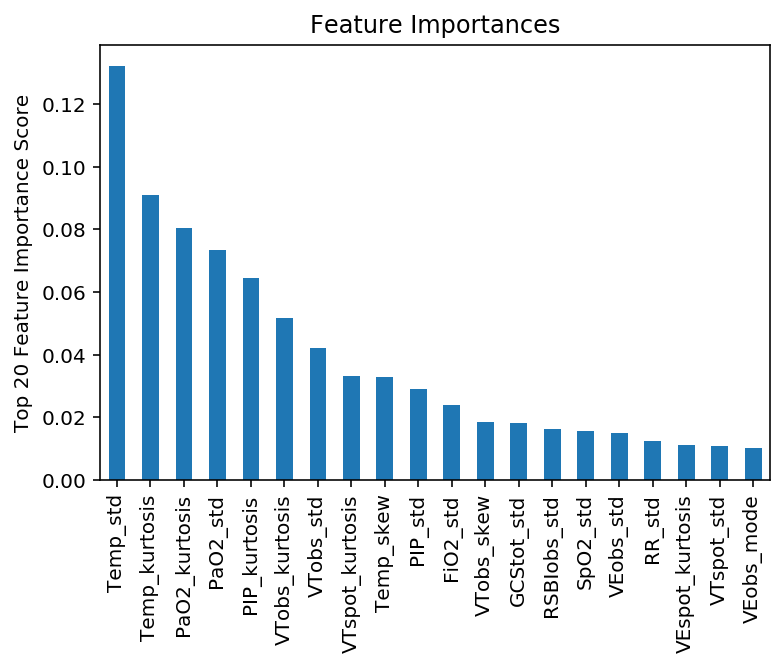

In [305]:
model_fit(clf_rf.best_estimator_, X_train, y_train, scorer, cv_folds=3)

In [306]:
print(classification_report(clf_rf.predict(X_test), y_test))

precision    recall  f1-score   support

           1       0.65      0.44      0.53       104
           2       0.21      0.25      0.23        61
           3       0.08      0.22      0.12        27
           4       0.46      0.36      0.40        92

    accuracy                           0.35       284
   macro avg       0.35      0.32      0.32       284
weighted avg       0.44      0.35      0.38       284



## Gradient Boosted Trees

In [307]:
parameters_gbt = {'n_estimators': range(20, 201, 10)}
gbt = GradientBoostingClassifier(learning_rate=0.1, random_state=10, max_features='sqrt', subsample=0.8, max_depth=2, min_samples_split=15, min_samples_leaf=2)
scorer = make_scorer(precision_score, average='macro')
# scorer = make_scorer(cohen_kappa_score)
clf_gbt = GridSearchCV(gbt, parameters_gbt, n_jobs=4, cv=3, verbose=10, scoring=scorer)

clf_gbt.fit(X_train, y_train)

print('\n-------- Done ---------\n')
means = clf_gbt.cv_results_['mean_test_score']
stds = clf_gbt.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_gbt.cv_results_['params']):
    print("{0:.3f} (+/-{1:.03f}) for {2}".format(mean, std * 2, params))

clf_gbt.best_params_, clf_gbt.best_score_

Fitting 3 folds for each of 19 candidates, totalling 57 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:   29.6s finished

-------- Done ---------

0.332 (+/-0.020) for {'n_estimators': 20}
0.328 (+/-0.018) for {'n_estimators': 30}
0.332 (+/-0.024) for {'n_estimators': 40}
0.332 (+/-0.033) for {'n_estimators': 50}
0.330 (+/-0.027) for {'n_estimators': 60}
0.341 (+/-0.016) for {'n_estimators': 70}
0.334 (+/-0.016) for {'n_estimators': 80}
0.338 (+/-0.022) for {'n_estimators': 90}
0.341 (+/-0.025) for {'n_estimators': 100}
0.329 (+/-0.033) for {'

({'n_estimators': 70}, 0.3410679675700967)


Model Report
Accuracy : 0.7217
Precision : 0.7207
Recall : 0.7217
              precision    recall  f1-score   support

           1       0.77      0.83      0.80       283
           2       0.70      0.61      0.65       283
           3       0.72      0.69      0.70       283
           4       0.69      0.76      0.72       283

    accuracy                           0.72      1132
   macro avg       0.72      0.72      0.72      1132
weighted avg       0.72      0.72      0.72      1132

CV Score : Mean - 0.341068 | Std - 0.008000426 | Min - 0.3347499 | Max - 0.3523555


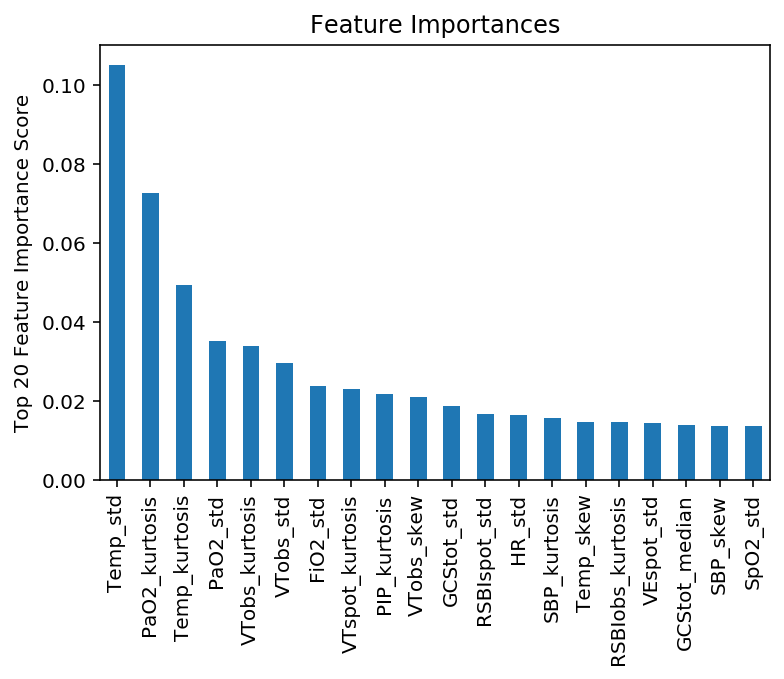

In [309]:
model_fit(clf_gbt.best_estimator_, X_train, y_train, scorer, cv_folds=3)

In [315]:
parameters_gbt = {'max_depth':range(2, 5, 2), 'min_samples_split':range(5, 31, 5), 'min_samples_leaf':range(2, 7, 2)}
gbt = GradientBoostingClassifier(learning_rate=0.1, random_state=10, n_estimators=100, max_features='sqrt', subsample=0.8)
scorer = make_scorer(precision_score, average='weighted')
clf_gbt = GridSearchCV(gbt, parameters_gbt, n_jobs=4, cv=3, verbose=10, scoring=scorer)

clf_gbt.fit(X_train, y_train)

print('\n-------- Done ---------\n')
means = clf_gbt.cv_results_['mean_test_score']
stds = clf_gbt.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_gbt.cv_results_['params']):
    print("{0:.3f} (+/-{1:.03f}) for {2}".format(mean, std * 2, params))

clf_gbt.best_params_, clf_gbt.best_score_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   24.9s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   42.5s
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:   54.9s finished

-------- Done ---------

0.325 (+/-0.028) for {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.339 (+/-0.003) for {'max_depth': 2, 'min_samples_leaf': 2, 'min_sample

({'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 25},
 0.352756467748148)


Model Report
Accuracy : 0.7765
Precision : 0.7769
Recall : 0.7765
              precision    recall  f1-score   support

           1       0.82      0.86      0.84       283
           2       0.75      0.70      0.72       283
           3       0.80      0.73      0.76       283
           4       0.74      0.82      0.78       283

    accuracy                           0.78      1132
   macro avg       0.78      0.78      0.78      1132
weighted avg       0.78      0.78      0.78      1132

CV Score : Mean - 0.3527565 | Std - 0.01001936 | Min - 0.3385954 | Max - 0.3602616


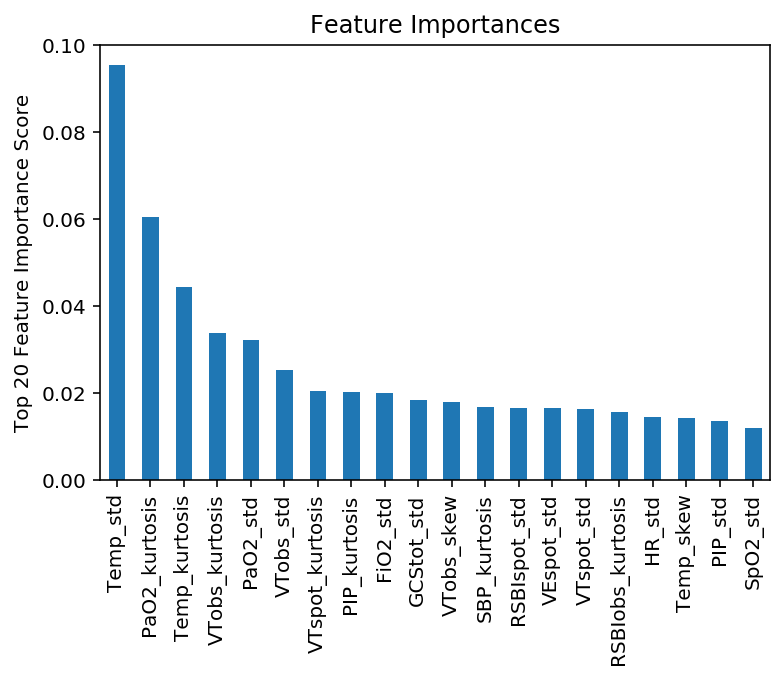

In [340]:
model_fit(clf_gbt.best_estimator_, X_train, y_train, scorer, cv_folds=3)

In [350]:
parameters_gbt = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gbt = GradientBoostingClassifier(learning_rate=0.1, random_state=10, n_estimators=100, max_features='sqrt', subsample=0.8, max_depth=2, \
    min_samples_split=25, min_samples_leaf=4)
scorer = make_scorer(precision_score, average='weighted')
clf_gbt = GridSearchCV(gbt, parameters_gbt, n_jobs=4, cv=3, verbose=10, scoring=scorer)

clf_gbt.fit(X_train, y_train)

print('\n-------- Done ---------\n')
means = clf_gbt.cv_results_['mean_test_score']
stds = clf_gbt.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_gbt.cv_results_['params']):
    print("{0:.3f} (+/-{1:.03f}) for {2}".format(mean, std * 2, params))

clf_gbt.best_params_, clf_gbt.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  13 out of  18 | elapsed:    6.5s remaining:    2.5s
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:    6.6s remaining:    1.3s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    7.5s finished

-------- Done ---------

0.343 (+/-0.006) for {'subsample': 0.6}
0.344 (+/-0.024) for {'subsample': 0.7}
0.348 (+/-0.038) for {'subsample': 0.75}
0.353 (+/-0.020) for {'subsample': 0.8}
0.330 (+/-0.025) for {'subsample': 0.85}
0.346 (+/-0.008) for {'subsample': 0.9}


({'subsample': 0.8}, 0.352756467748148)

In [352]:
parameters_gbt = {'learning_rate': np.logspace(-3, 0, 10), 'n_estimators': range(20, 201, 20)}
gbt = GradientBoostingClassifier(learning_rate=0.1, random_state=10, n_estimators=100, max_features='sqrt', subsample=0.8, max_depth=2, \
    min_samples_split=25, min_samples_leaf=4)
scorer = make_scorer(precision_score, average='weighted')
clf_gbt = GridSearchCV(gbt, parameters_gbt, n_jobs=4, cv=3, verbose=10, scoring=scorer)

clf_gbt.fit(X_train, y_train)

print('\n-------- Done ---------\n')
means = clf_gbt.cv_results_['mean_test_score']
stds = clf_gbt.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_gbt.cv_results_['params']):
    print("{0:.3f} (+/-{1:.03f}) for {2}".format(mean, std * 2, params))

clf_gbt.best_params_, clf_gbt.best_score_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   25.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   34.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   37.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   43.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   58.4s
[Paralle

({'learning_rate': 0.1, 'n_estimators': 80}, 0.3602901339548718)


Model Report
Accuracy : 0.7341
Precision : 0.7336
Recall : 0.7341
              precision    recall  f1-score   support

           1       0.78      0.84      0.81       283
           2       0.71      0.65      0.68       283
           3       0.74      0.68      0.71       283
           4       0.71      0.77      0.74       283

    accuracy                           0.73      1132
   macro avg       0.73      0.73      0.73      1132
weighted avg       0.73      0.73      0.73      1132

CV Score : Mean - 0.3602901 | Std - 0.009587951 | Min - 0.3468439 | Max - 0.3685271


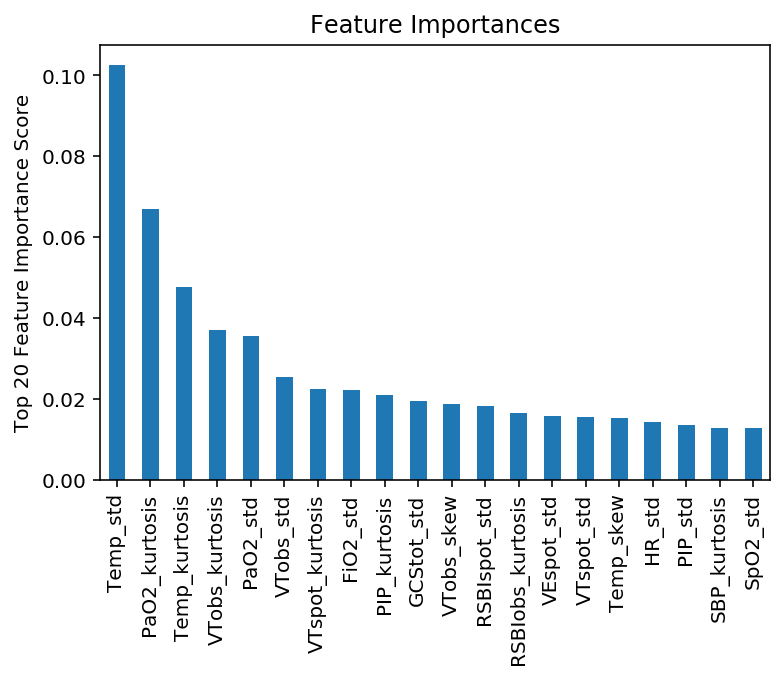

In [358]:
model_fit(clf_gbt.best_estimator_, X_train, y_train, scorer, cv_folds=3)

In [359]:
print(classification_report(clf_gbt.best_estimator_.predict(X_test), y_test))

precision    recall  f1-score   support

           1       0.59      0.58      0.58        73
           2       0.17      0.19      0.18        62
           3       0.14      0.18      0.16        55
           4       0.37      0.28      0.32        94

    accuracy                           0.32       284
   macro avg       0.32      0.31      0.31       284
weighted avg       0.34      0.32      0.32       284




Model Report
Accuracy : 0.6829
Precision : 0.6836
Recall : 0.6829
              precision    recall  f1-score   support

           1       0.74      0.79      0.76       354
           2       0.67      0.60      0.63       354
           3       0.69      0.62      0.65       354
           4       0.64      0.73      0.68       354

    accuracy                           0.68      1416
   macro avg       0.68      0.68      0.68      1416
weighted avg       0.68      0.68      0.68      1416

CV Score : Mean - 0.4035778 | Std - 0.006518448 | Min - 0.3943772 | Max - 0.4086748


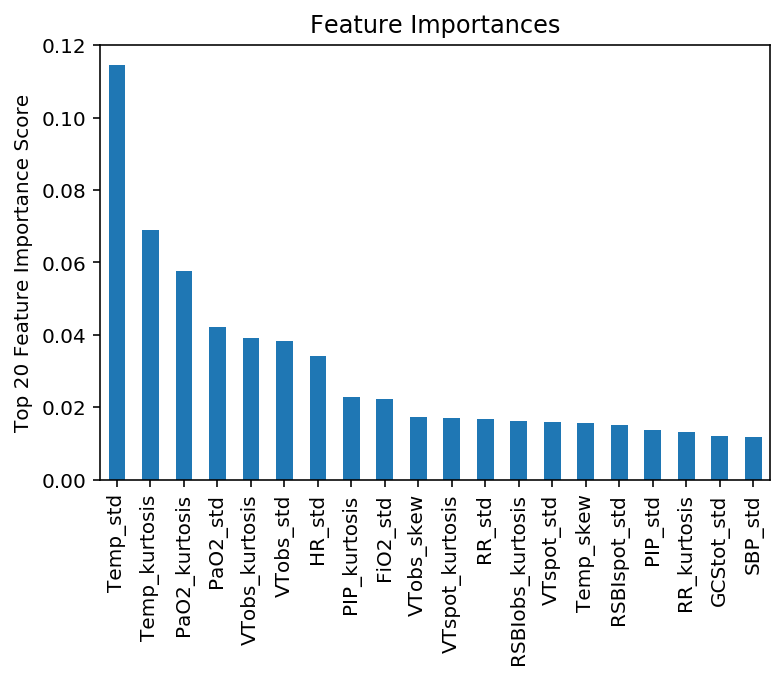

In [360]:
model_fit(clf_gbt.best_estimator_, X, y, scorer, cv_folds=3)

In [370]:
print(classification_report(clf_gbt.best_estimator_.predict(X_test), y_test))

precision    recall  f1-score   support

           1       0.73      0.72      0.73        72
           2       0.62      0.62      0.62        71
           3       0.61      0.69      0.65        62
           4       0.69      0.62      0.65        79

    accuracy                           0.66       284
   macro avg       0.66      0.66      0.66       284
weighted avg       0.66      0.66      0.66       284



[Text(334.8, 362.4, 'X[59] <= 9.991\nfriedman_mse = 0.188\nsamples = 1132\nvalue = 0.001'),
 Text(167.4, 217.44, 'X[75] <= -0.064\nfriedman_mse = 0.176\nsamples = 1027\nvalue = -0.022'),
 Text(83.7, 72.47999999999996, 'friedman_mse = 0.126\nsamples = 570\nvalue = -0.411'),
 Text(251.10000000000002, 72.47999999999996, 'friedman_mse = 0.22\nsamples = 457\nvalue = 0.313'),
 Text(502.20000000000005, 217.44, 'X[32] <= 12.5\nfriedman_mse = 0.249\nsamples = 105\nvalue = 0.226'),
 Text(418.5, 72.47999999999996, 'friedman_mse = 0.181\nsamples = 21\nvalue = -0.048'),
 Text(585.9, 72.47999999999996, 'friedman_mse = 0.249\nsamples = 84\nvalue = 1.143')]

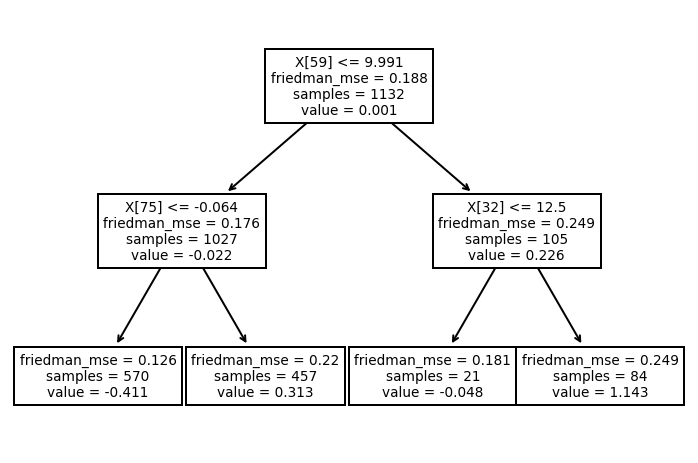

In [367]:
from sklearn.tree import plot_tree
plot_tree(clf_gbt.best_estimator_.estimators_[0][0])

In [372]:
# save the trained model
import joblib
filename = './data/gbt_model_eval-hours{0}_seg-size-hours{1}.sav'.format(total_num_hours, seg_size_hours)
joblib.dump(clf_gbt.best_estimator_, filename)

['./analysis/gbt_model_eval-hours12_seg-size-hours3.sav']

In [365]:
loaded_model = joblib.load(filename)